In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from IPython import display
import random

In [2]:
# Hyper Parameters for DQN
BATCH_SIZE = 128            # training batch
LR = 0.01                   # learning rate
EPSILON = 0.9               # greedy policy
GAMMA = 0.9                 # reward discount
TARGET_REPLACE_ITER = 10   # target update frequency
MEMORY_CAPACITY = 100
N_ACTIONS = 1001    # 1000 values
N_STATES = 2        # [set value, process output value]

In [3]:
if torch.cuda.is_available():
    cuda = True
else:
    cuda = False

In [4]:
cuda

False

In [ ]:
def cuda_if(torch_object, cuda):
    return torch_object.cuda() if cuda else torch_object

In [5]:
class Net(nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        self.fc1=cuda_if(nn.Linear(N_STATES, 50), cuda)
        self.fc1.weight.data.normal_(0, 0.1)   # initialization
        self.out = cuda_if(nn.Linear(50, N_ACTIONS), cuda)
        self.out.weight.data.normal_(0, 0.1)   # initialization

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        actions_value = self.out(x)
        return actions_value

In [6]:
class DQN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter = 0                                     # for target updating
        self.memory_counter = 0                                         # for storing memory
        self.memory = np.zeros((MEMORY_CAPACITY, N_STATES * 2 + 2))     # initialize memory
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=LR)
        self.loss_func = nn.MSELoss()

    def choose_action(self, x):
        x = cuda_if(torch.unsqueeze(torch.FloatTensor(x), 0), cuda)
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].cpu().data.numpy()
            action = action[0]  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action 
        return action

    def take_action(self, a): # 0~1000 * 0.01 = 0 to 10
        value = a*0.01
        return value
    
    def reward(self, s):  # s = [set_value, process_output]
        error = abs(s[1] -s[0]) # process_output - set_value
        r = -(error**2)*1000
        return r
    
    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, [a, r], s_))
        # replace the old memory with new memory
        index = self.memory_counter % MEMORY_CAPACITY
        self.memory[index, :] = transition
        self.memory_counter += 1

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch transitions
        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
        b_memory = self.memory[sample_index, :]
        
        b_s = cuda_if(torch.FloatTensor(b_memory[:, :N_STATES]), cuda)
        b_a = cuda_if(torch.LongTensor(b_memory[:, N_STATES:N_STATES+1].astype(int)), cuda)
        b_r = cuda_if(torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2]), cuda)
        b_s_ = cuda_if(torch.FloatTensor(b_memory[:, -N_STATES:]), cuda)
        
        # q_eval w.r.t the action in experience
        q_eval = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        q_next = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)   # shape (batch, 1)
        loss = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [7]:
dqn = DQN()

### Debug: test dqn functions

In [8]:
a = dqn.choose_action([1.5, 2.0])
print(a)

448


In [9]:
r = dqn.reward([1.5, 2.0])
print(r)

-250.0


In [10]:
#  dqn.store_transition(s, a, r, s_)
dqn.store_transition([1.5, 2.0], 2, 3.5, [1.6, 2.1])

# Define the control process  

In [11]:
# Hyper Parameters for process
ns = 2000  # number of steps
t = np.linspace(0,ns/10,ns+1) # time points, if 10 control steps/per second, then 1 min. has 600 steps 
delta_t = t[1]-t[0]

KP=1.0    # process gain
TAUP =20.0 #process time constant

sv = np.zeros(ns+1)  # set point
p_out = np.zeros(ns+1)  # record process output
p_out_unit_step = np.zeros(ns+1)  # process output from unit step
action = np.zeros(ns+1) #RL Controller output
reward = np.zeros(ns+1)

In [12]:
# process model
def process(y,t,u,KP,TAUP):
    dydt = -y/TAUP + KP/TAUP * u
    return dydt

## Debug: test process functions

In [13]:
y = odeint(process,5.0,[0,delta_t],args=(5.03,3.0,2.0))

In [14]:
y

array([[5.        ],
       [5.49209502]])

In [15]:
y[-1][0]

5.49209502396743

In [16]:
# run the process ns steps and collect output data
# increase by 0.01 every control step
sv[0:] = 10 #set value
action[0] = 0.0
p_out[1] = 3.0
for i in range(1,ns):         
    action[i] = action[i-1]+ 0.01
    y = odeint(process,p_out[i],[0,delta_t],args=(action[i],KP,TAUP))
    p_out[i+1] = y[-1][0]

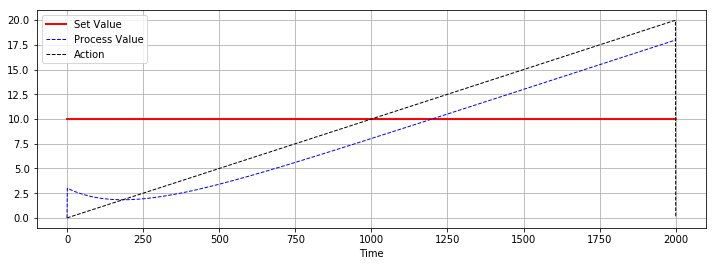

In [17]:
plt.figure(figsize=(12,4)) 
plt.plot(sv, 'r', lw =2, label='Set Value')
plt.plot(p_out, 'b--', lw =1, label='Process Value')
plt.plot(action, 'k--', lw =1, label='Action')
plt.legend(loc = 'best')
plt.xlabel('Time')
plt.grid(True)
plt.show()

# Introduce noises to actions  

In [18]:
n_a = 1.0
noise= (n_a)+n_a*np.sin(np.linspace(0., (10)*np.pi, ns+1))

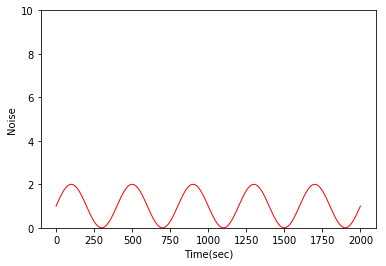

In [19]:
# draw noises
plt.plot(noise, 'r-', lw =1)
plt.xlabel('Time(sec)')
plt.ylabel('Noise')
plt.ylim([0, 10])
plt.show()

In [20]:
# run the process ns steps and collect output data
# increase by 0.01 every control step
sv[0:] = 10 #set value
action[0] = 0.0
p_out[1] = 3.0
for i in range(1,ns):         
    action[i] = action[i-1]+ 0.01
    y = odeint(process,p_out[i],[0,delta_t],args=(action[i]+noise[i],KP,TAUP))
    p_out[i+1] = y[-1][0]

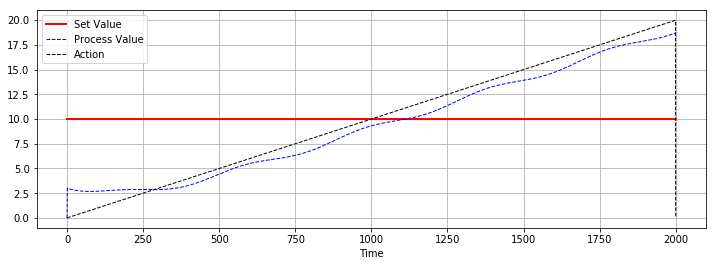

In [21]:
plt.figure(figsize=(12,4)) 
plt.plot(sv, 'r', lw =2, label='Set Value')
plt.plot(p_out, 'b--', lw =1, label='Process Value')
plt.plot(action, 'k--', lw =1, label='Action')
plt.legend(loc = 'best')
plt.xlabel('Time')
plt.grid(True)
plt.show()

# Train DQN to learn process control

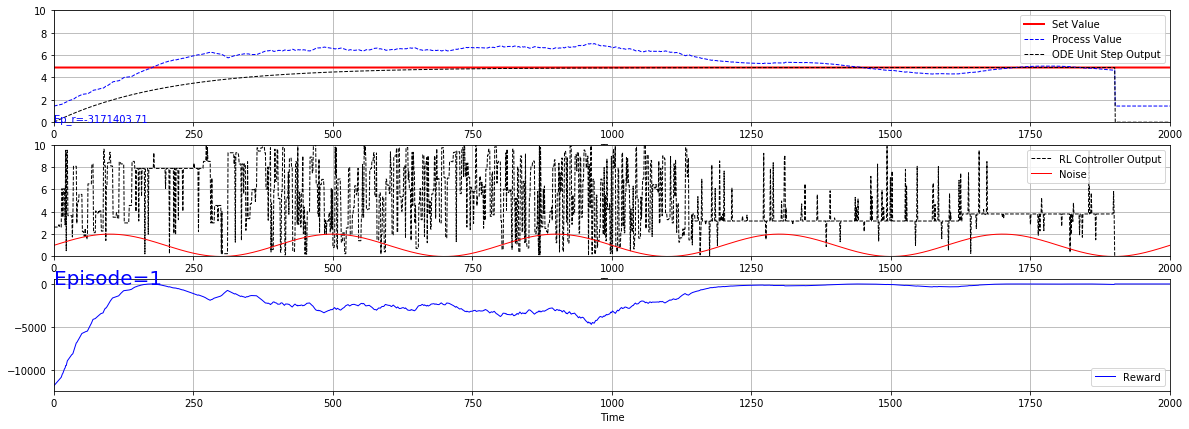

In [29]:
ep_rLst = []
for i_episode in range(1, 3):
    p_out[:]=0.0  #reset plot
    p_out_unit_step[:]=0
    action[:]=0 
    reward[:]=0
    
    sv[0:] = np.random.uniform(3.0, 7.0)
    p_out[0:] = np.random.uniform(0.1, 8)
    ep_r = 0
    
    # initialize environment to create the first state
    s = [sv[0], p_out[0]]  # state = [set_value, process_output]    
    for i in range(0, ns): # run control steps
        # as a benchmark, calculate output from unit step 
        y = odeint(process, p_out_unit_step[i],[0,delta_t],args=(sv[i],KP,TAUP))
        p_out_unit_step[i+1] = y[-1][0]
        
        # Q-learning
        a = dqn.choose_action(s)         # choose action index 0~1000
        action[i] = dqn.take_action(a)   # 0~1000 * 0.01 = 0~10 
        y = odeint(process, p_out[i],[0,delta_t],args=(action[i]+noise[i],KP,TAUP))
        p_out[i+1] = y[-1][0]
        s_ = [sv[i+1], p_out[i+1]]   # next state
        r = dqn.reward(s_)  
        dqn.store_transition(s, a, r, s_)
        ep_r += r
        reward[i] = r
        if dqn.memory_counter > MEMORY_CAPACITY:
            dqn.learn()
        s = s_
        
        if(i%100 == 0):
            # draw process control performance
            display.clear_output(wait=True)
            fig=plt.figure(figsize=(20,7)) 
            plt.subplot(3, 1, 1)  # 3 rows, 1 column
            plt.plot(sv, 'r', lw =2, label='Set Value')
            plt.plot(p_out, 'b--', lw =1, label='Process Value')
            plt.plot(p_out_unit_step, 'k--', lw =1, label='ODE Unit Step Output')
            plt.legend(loc = 'best')
            plt.xlabel('Time')
            plt.ylim(0,10.0)
            plt.xlim(0,ns)
            plt.text(0.5, 0.1, 'Ep_r=%.2f' % ep_r, fontdict={'size':10, 'color': 'blue'})
            plt.grid(True)

            plt.subplot(3, 1, 2)  
            plt.plot(action, 'k--', lw =1, label='RL Controller Output')
            plt.plot(noise, 'r', lw =1, label='Noise')    
            plt.legend(loc = 'best')
            plt.xlabel('Time')
            plt.ylim(0,10.0)
            plt.xlim(0,ns)
            plt.grid(True)

            plt.subplot(3, 1, 3)  
            plt.plot(reward, 'b', lw =1, label='Reward')
            plt.legend(loc = 'best')
            plt.xlabel('Time')
            plt.xlim(0,ns)
            plt.text(0.5, 0.1, 'Episode=%d' % i_episode, fontdict={'size':20, 'color': 'blue'})
            plt.grid(True)
            plt.pause(0.1)
    # finish one episode 
    ep_r = round(ep_r, 2)
    ep_rLst.append(ep_r)

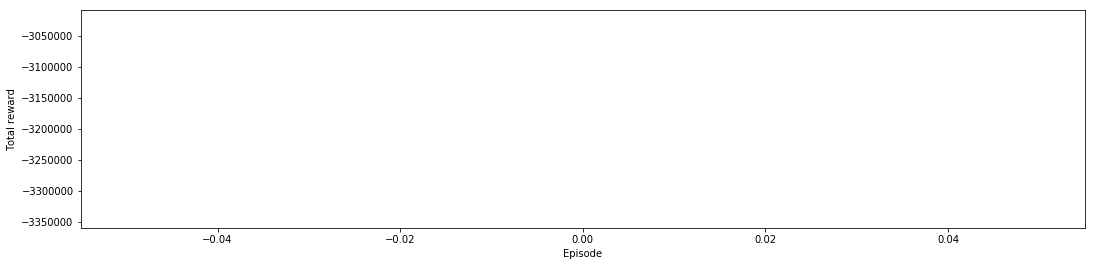

In [30]:
plt.figure(figsize=(18,4)) 
plt.plot(ep_rLst, 'b', lw =1)
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()

In [ ]:
torch.save(dqn.eval_net.state_dict(), 'dqn.pkl') # parameters